In [4]:
import jax
# Enable Float64 for more stable matrix inversions.
jax.config.update("jax_enable_x64", True)

from dataclasses import dataclass
import warnings
from typing import List, Union
import pandas as pd
import cola


import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from gpjax.distributions import GaussianDistribution
from gpjax.kernels import AdditiveKernel

import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams.update(mpl.rcParamsDefault)

#imports AdditiveConjugatePosterior
# from OAK import AdditiveConjugatePosterior

from pprint import pprint
import numpy as np
def calculate_nlpd(predictive_mean, predictive_stddev, actual_values):
    variance = predictive_stddev ** 2
    nlpd_sum = 0.5 * np.log(2 * np.pi * variance) + ((predictive_mean - actual_values) ** 2) / (2 * variance)
    total_nlpd = np.sum(nlpd_sum)
    return total_nlpd

## This is where I shall add in the dataset

This can be changed according to which data is useful and can be found in GPJAX/docs/examples/datasets



In [5]:
#Seoul Biking Data
# dataset_path = "/home/sharmakd/python_dev/GPJax/docs/examples/datasets/FilesToUnzip/SeoulBikeData.csv"
# mydata = pd.read_csv(dataset_path, sep = ",", encoding='latin1')
# mydata.drop(['Date','Seasons','Holiday','Functioning Day','Snowfall (cm)','Rainfall(mm)','Visibility (10m)'], axis=1, inplace=True)

#Leaves Data
dataset_path = "/home/sharmakd/python_dev/GPJax/docs/examples/datasets/LitterData/litter_data.csv"
mydata = pd.read_csv(dataset_path, sep = ",", encoding='latin1')
mydata.drop(['CombinaisonID','Replicates','Code','mix_ID','CN','CP','NP'], axis=1, inplace=True)

# print("Number of rows: " + str(mydata.shape[0]),"Number of columns: " + str(mydata.shape[1]), "Columns: " + str(mydata.columns), sep = "\n")
# for column in mydata.columns:
#     print("Column: " + str(column), "Number of Unique Values: " + str(mydata[column].nunique()), sep = " "*5)

mydata = mydata.dropna()
mydata = mydata.drop_duplicates()
# mydata = mydata[:200]
mydata

,decay,N,C,P,lignin,cellulose,hemicellulose,wsc
0,0.434353,0.392836,50.476072,0.030668,23.446044,26.263114,16.438417,33.852424
4,0.643130,0.910458,46.600733,0.052863,27.025629,19.427871,16.160416,37.386083
8,0.488936,0.706277,50.577534,0.102700,33.794060,15.156320,15.967230,35.082390
12,0.443418,0.651647,48.538403,0.041765,25.235837,22.845493,16.299417,35.619254
16,0.447851,0.549556,50.526803,0.066684,28.620052,20.709717,16.202824,34.467407
...,...,...,...,...,...,...,...,...
448,0.697638,0.733958,46.438689,0.031786,13.093907,18.940731,19.502455,48.462907
452,0.716840,0.630201,48.967963,0.037184,13.675851,19.526760,15.967105,50.830284
456,0.686831,0.616659,49.532436,0.053036,15.607871,19.290788,15.659274,49.442067
460,0.670501,0.428877,48.395354,0.014333,14.089021,19.298878,18.863363,47.748738


## This step is to test datasets to see if they need scaling or transforming

In [6]:
# n, noise = 400, 0.001
# key = jax.random.PRNGKey(np.random.randint(50))  # Replace 12345 with any desired seed value
# X = jr.uniform(key, (n, len(lof)))
# y = f(X) + jr.normal(key, (n, 1)) * noise
#Select Data wanted
# X = jnp.array(X)
# y = jnp.array(y).reshape(-1, 1) 
# D = gpx.Dataset(X, y)
# feature_dimension = X.shape[1]

# to_predict = 'Rented Bike Count'
to_predict = 'decay'

feature_data = mydata.drop(to_predict, axis=1)
column_names = feature_data.columns
X = jnp.array(feature_data)
y = jnp.array(mydata[to_predict]).astype(float).reshape(-1, 1)
feature_dimension = X.shape[1]

# Split the data into training and test sets
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
print(Xtr.shape, Xte.shape, ytr.shape, yte.shape)

(93, 7) (24, 7) (93, 1) (24, 1)


In [7]:
scaleX = True
if scaleX:
    x_scaler = StandardScaler().fit(Xtr)
    scaled_Xtr = x_scaler.transform(Xtr)
    scaled_Xte = x_scaler.transform(Xte)
else:
    scaled_Xtr = Xtr
    scaled_Xte = Xte

scaleY = True
if scaleY:
    y_scaler = StandardScaler().fit(ytr)
    scaled_ytr = y_scaler.transform(ytr)
    scaled_yte = y_scaler.transform(yte)
else:
    scaled_ytr = ytr
    scaled_yte = yte

D = gpx.Dataset(scaled_Xtr, scaled_ytr)

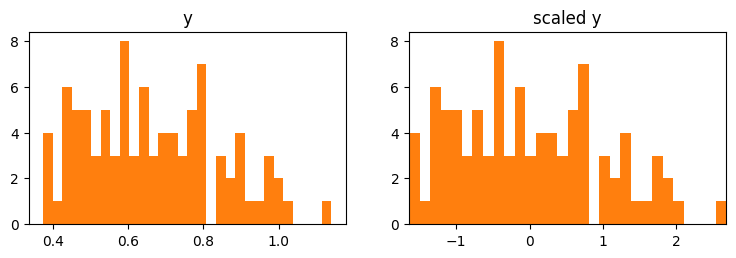

In [8]:
fig, ax = plt.subplots(ncols= 2, figsize=(9, 2.5))
ax[0].hist(ytr.reshape(1, -1).flatten(), bins=30, color=cols[1])
ax[0].set_title("y")
ax[1].hist(scaled_ytr.reshape(1, -1).flatten(), bins=30, color=cols[1])
ax[1].set_title("scaled y")
ax[1].set_xlim(scaled_ytr.min(), scaled_ytr.max())
plt.show()

This looks good! 

## Work on the Posterior Now!

Now lets try on the dataset. we fit additive models of `max_interaction_depth` 0 (i.e. a constant model), 1 and 2.

We can also look at the individual additive components learned by the second order model

In [18]:
class AdditiveConjugatePosterior(gpx.gps.ConjugatePosterior):
    r"""        
    Build an additive posterior from an additive kernel and a Gaussian likelihood. We have included an
    additional method to allow predictions for specific additive components, as specified by a
    component_list, e.g. [0, 1] corresponds to the second order interaction between zeroth and first inputs.
    """

    def __post__init__(self):
        assert isinstance(self.prior.kernel, AdditiveKernel), "AdditiveConjugatePosterior requires an AdditiveKernel"

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: gpx.Dataset,
        component_list: List[List[int]]
    ) -> GaussianDistribution:
        r"""Get the posterior predictive distribution for a specific additive component."""
        specific_kernel = self.prior.kernel.get_specific_kernel(component_list)
        return self.predict(test_inputs, train_data, kernel_with_test = specific_kernel)

    def get_sobol_index(self, train_data: gpx.Dataset, component_list: List[int]) -> ScalarFloat:
        """ Return the sobol index for the additive component corresponding to component_list. """
        component_posterior = self.predict_additive_component(train_data.X, train_data, component_list)
        full_posterior= self.predict(train_data.X, train_data) # wasteful as only need means
        return jnp.var(component_posterior.mean()) #/ jnp.var(full_posterior.mean())
    
@dataclass()
class OrthogonalRBF(gpx.kernels.AbstractKernel):
    r"""todo only for unit gaussian input measure and zero mean."""
    name: str = "OrthogonalRBF"
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = gpx.param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )

    def __post_init__(self):
        warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute an orthogonal RBF kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.exp(-0.5 * ((x - y) / self.lengthscale) ** 2) # [d]
        ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
        return jnp.prod(ks)
    
    def _cov_x_s(self,x):
        l2 = self.lengthscale ** 2
        return jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (x ** 2) / (l2 + 1.0)) # [d]
        
    def _var_s(self):
        return  jnp.sqrt(self.lengthscale ** 2 / (self.lengthscale ** 2 + 2.0)) # [d]

In [17]:
def plot_posterior_with_components(opt_posterior, D: gpx.Dataset, sobol=False):
    fig, ax = plt.subplots(ncols=1, nrows=feature_dimension, figsize=(6, 6 * feature_dimension))
    for i in range(feature_dimension): # make 1d plots of 1d interactions
        column = D.X[:,i]
        std = column.std()
        xplot1d = mesh([i], min = column.min() - std, max= column.max() + std, NumPoints = NumPoints)

        posterior = opt_posterior.predict_additive_component(xplot1d, D, [i])
        mean, std = posterior.mean(), posterior.stddev()
        ax[i].plot(xplot1d[:,i], mean, color="blue", label="additive")
        ax[i].fill_between(xplot1d[:,i], mean - 2 * std,mean + 2 * std, alpha=0.2, color="blue")
        ax[i].set_title(column_names[i] if not sobol else column_names[i] + f" has sobol ${opt_posterior.get_sobol_index(D, [i]):.2f}$")
        ax[i].legend()
        ax[i].scatter(column, D.y, c="red", marker="x", label="data")
    # pprint(opt_posterior.__dict__)

def plot_posterior_with_components2d(opt_posterior, D, active_dimensions: list[int] = [0, 1], sobol = False):
        if len(active_dimensions) != 2:
            raise ValueError("Only 2 active dimensions are supported")
        contour_plot(
                opt_posterior = opt_posterior,
                active_dimensions = active_dimensions,
                D = D,
                sobol = True,
                )

CHOSEN INTERACTION VARIANCES ARE [10.02154428  0.10506745]


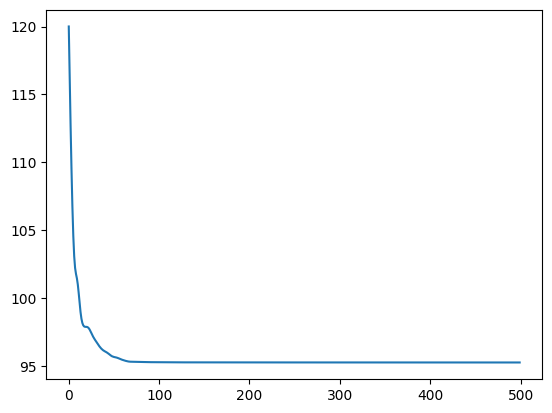

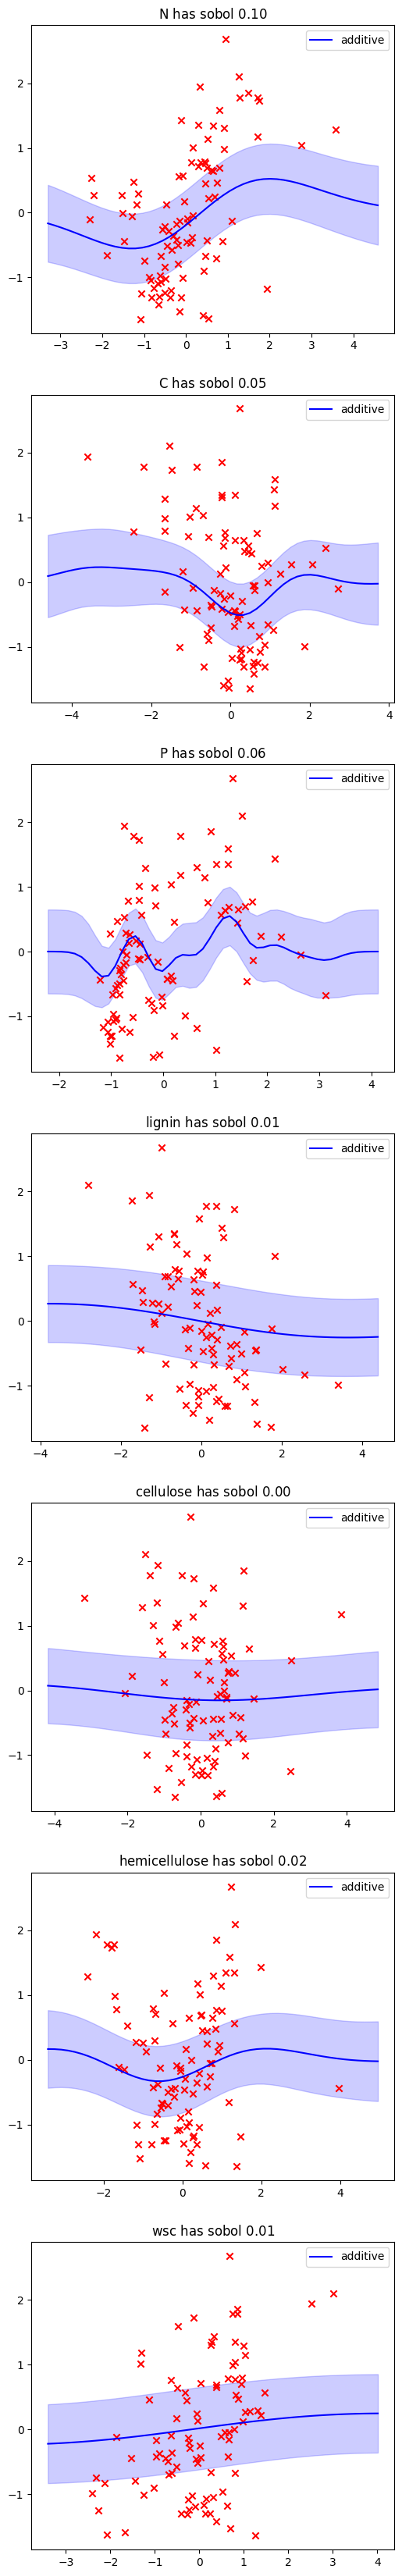

In [39]:
trainable_noise = True

D = gpx.Dataset(X=scaled_Xtr, y=scaled_ytr)
noise = jnp.array(1.0, dtype=jnp.float64)
meanf = gpx.mean_functions.Zero()
# periodic_kernel = gpx.kernels.Periodic(period= 24.0, lengthscale=jnp.array([1.0]))
# periodic_kernel.replace_trainable(period=True)
# periodic_kernel = gpx.kernels.RBF(active_dims=[0], lengthscale=jnp.array([1.0]))
# base_kernels = [periodic_kernel] + [gpx.kernels.RBF(active_dims=[i], lengthscale=jnp.array([1.0])) for i in range(feature_dimension - 1)]

base_kernels = [gpx.kernels.RBF(active_dims=[i], 
                                lengthscale=jnp.array([1.0], dtype=jnp.float64),
                                variance= jnp.array(1.0, dtype=jnp.float64),
                                ).replace_trainable(variance = False)\
                                .replace_bijector(
                                    lengthscale=tfb.Softplus(low=jnp.array([0.1], dtype=jnp.float64)), 
                                    variance=tfb.SoftClip(low=jnp.array([0.001], dtype=jnp.float64))
                                ) for i in range(feature_dimension)]
# base_kernels = [OrthogonalRBF(active_dims=[i], lengthscale=jnp.array([1.0])) for i in range(feature_dimension)]
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)
if not trainable_noise:
    likelihood = likelihood.replace_trainable(obs_stddev=False)
obj = gpx.objectives.ConjugateLOOCV(negative=True)
# obj = gpx.objectives.ConjugateMLL(negative=True)
maximum_interaction_depth = 1
kernel = AdditiveKernel(
    kernels=base_kernels,
    interaction_variances=jnp.array([1.0]*(maximum_interaction_depth + 1)) * jnp.var(D.y), 
    max_interaction_depth=maximum_interaction_depth, 
    )\
    .replace_bijector(interaction_variances=tfb.Softplus(low=jnp.array([0.05], dtype=jnp.float64)))
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
posterior = AdditiveConjugatePosterior(prior =prior, likelihood=likelihood)

def best_optimiser(model,
                    obj,
                    train_data,
                    optimiser_list: list[ox.GradientTransformation],
                    num_iters = 500,
                    key = jr.PRNGKey(0),
                    safe = False,
                    verbose = False
                    ):
    final_min = float('inf')
    opt_posterior_final = None
    for optim in optimiser_list:
        opt_posterior, history = gpx.fit(
            model=model,
            objective=obj,
            train_data=train_data,
            optim=optim,
            num_iters=num_iters,
            key=key, 
            safe=safe,
            verbose=verbose)
        if history[-1] < final_min:
            final_min = history[-1]
            opt_posterior_final = opt_posterior
    return opt_posterior_final, history

opt_posterior, history = best_optimiser(posterior, 
    obj, 
    D, 
    [
    ox.adam(0.1), 
    # ox.adam(1.0),
    # ox.yogi(0.5), 
    # ox.adam(0.01),
    ], 
    num_iters=300, 
    key=jr.PRNGKey(0), 
    safe=False, 
    verbose=False)

# These are to check if the history is converging or not if the model does not fit well
plt.figure()
plt.plot(history)
# pprint(opt_posterior.__dict__)
print(f"CHOSEN INTERACTION VARIANCES ARE {opt_posterior.prior.kernel.interaction_variances}")

plot_posterior_with_components(
    opt_posterior=opt_posterior,
    D=D,
    sobol=True,
)
plt.show()

# for i in range(feature_dimension):
#     for j in range(i + 1, feature_dimension):
#         plot_posterior_with_components2d(
#             opt_posterior=opt_posterior,
#             active_dimensions=[i, j],
#             D = D,
#             sobol = True,
#         )   


In [23]:
# pprint(opt_posterior)

In [20]:
from itertools import combinations

##We look at all possible up to dth order interactions and their sobol indices

def subset_of(feature_dimension, depth):
    if depth > feature_dimension:
        raise ValueError("Depth cannot be greater than the number of features")
    subsets = []
    for r in range(1, depth + 1):
        subsets.extend(combinations(range(feature_dimension), r))
    return [list(tuples) for tuples in subsets]

# sum = 0
# for subset in subset_of(feature_dimension, maximum_interaction_depth):
#     x = opt_posterior.get_sobol_index(D, subset)
#     sum += x
#     if x > 0.001:
#         print(str([column_names[i] for i in subset]) + f" has sobol {x:.3f}")
# print(sum)

results = []
for subset in subset_of(feature_dimension, maximum_interaction_depth):
    results.append([subset, opt_posterior.get_sobol_index(D, subset)])
sorted(results, key = lambda x: x[1])
pprint(results[:10])




[[[0], Array(0.10304886, dtype=float64)],
 [[1], Array(0.05360184, dtype=float64)],
 [[2], Array(0.06295612, dtype=float64)],
 [[3], Array(0.01043597, dtype=float64)],
 [[4], Array(0.00090741, dtype=float64)],
 [[5], Array(0.01934931, dtype=float64)],
 [[6], Array(0.00721039, dtype=float64)]]


## Here we use metrics for testings the model against its test points

We implement metrices of fit:
NLPD, the negative log predictive density


In [28]:
def calculate_nlpd(predictive_mean, predictive_stddev, actual_values):
    variance = predictive_stddev ** 2
    nlpd_sum = 0.5 * np.log(2 * np.pi * variance) + ((predictive_mean - actual_values) ** 2) / (2 * variance)
    total_nlpd = np.sum(nlpd_sum)
    return total_nlpd


#we are using the best_posterior from the optimization

latent_dist = opt_posterior(scaled_Xte, D)
predictive_dist = likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_stddev = predictive_dist.stddev()


rmse = mean_squared_error(y_true=scaled_yte.squeeze(), y_pred=predictive_mean)
r2 = r2_score(y_true=scaled_yte.squeeze(), y_pred=predictive_mean)
nlpd = calculate_nlpd(predictive_mean, predictive_stddev, scaled_yte.squeeze())
all_X_data = np.concatenate((scaled_Xtr[:],scaled_Xte[:]),axis=0)
all_y_data = np.concatenate((scaled_ytr,scaled_yte),axis=0)
allD=gpx.Dataset(X=all_X_data, y=all_y_data)
cross_validation_score = obj(posterior=opt_posterior, train_data=allD)

print("RMSE: ", rmse)
print("R2: ", r2)
print("NLPD: ", nlpd)
print("Cross Validation Score: ", cross_validation_score)


save_file = False
file_name = 'SeoulBikeData'
file_path = '/home/sharmakd/python_dev/GPJax/docs/examples/datasetsoutputs/' + file_name + "/" + file_name + str(maximum_interaction_depth) + 'maximum_interaction_depth.txt' 

if save_file:
    import os
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'w+') as f:
        f.write("RMSE: " + str(rmse) + "\n")
        f.write("R2: " + str(r2) + "\n")
        f.write("NLPD: " + str(nlpd) + "\n")
        f.write("Cross Validation Score: " + str(cross_validation_score) + "\n")
        f.write("Sobol Indices: " + "\n")
        for subset in subset_of(feature_dimension, maximum_interaction_depth):
            x = opt_posterior.get_sobol_index(D, subset)
            f.write(str([column_names[i] for i in subset]) + f" has sobol {x:.3f}" + "\n")


RMSE:  0.3227033933953926
R2:  0.734655034152856
NLPD:  26.38028611164153
Cross Validation Score:  114.25162202039753


Text(0.5, 1.0, 'Residuals')

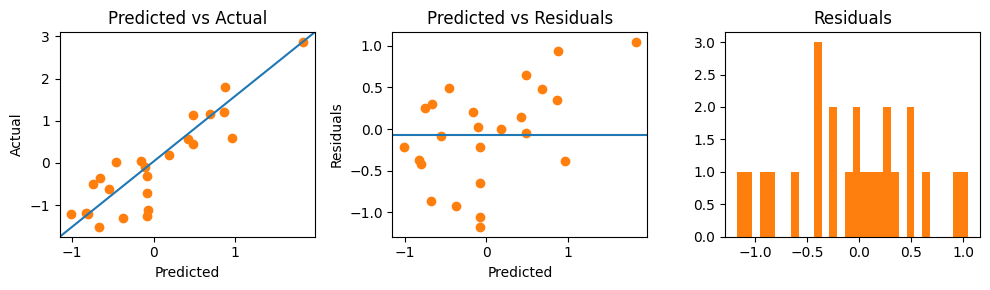

In [22]:
residuals = scaled_yte.squeeze() - predictive_mean

fig, ax = plt.subplots(ncols=3, figsize=(10, 3), tight_layout=True)

ax[0].scatter(predictive_mean, scaled_yte.squeeze(), color=cols[1])
ax[0].plot([0, 1], [0, 1], color=cols[0], transform=ax[0].transAxes)
ax[0].set(xlabel="Predicted", ylabel="Actual", title="Predicted vs Actual")

ax[1].scatter(predictive_mean.squeeze(), residuals, color=cols[1])
ax[1].plot([0, 1], [0.5, 0.5], color=cols[0], transform=ax[1].transAxes)
# ax[1].set_ylim([-1.0, 1.0])
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")

ax[2].hist(np.asarray(residuals), bins=30, color=cols[1])
ax[2].set_title("Residuals")